In [3]:
import pandas as pd
import numpy as np
import random
from IPython.display import Image
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import networkx as nx
from networkx.algorithms import community
# Node2Vec
from sklearn.preprocessing import normalize

In [4]:
# Load the adjacency matrix into a numpy array.
ad_mat = np.loadtxt('../AD.txt', dtype=int)
for i in range(0,70):
        ad_mat[i][i] = 0
G_AD = nx.from_numpy_matrix(ad_mat)
print("Number Of Edges: ",len(G_AD.edges()))
print("Number Of Nodes: ",len(G_AD.nodes()))

Number Of Edges:  1364
Number Of Nodes:  70


In [5]:
emci_mat = np.loadtxt('../eMCI.txt', dtype=int)
#removing self loops
for i in range(0,70):
        emci_mat[i][i] = 0
G_eMCI = nx.from_numpy_matrix(emci_mat)
print("Number Of Edges: ",len(G_eMCI.edges()))
print("Number Of Nodes: ",len(G_eMCI.nodes()))

Number Of Edges:  1510
Number Of Nodes:  70


In [6]:
lmci_mat = np.loadtxt('../lMCI.txt', dtype=int)
#removing self loops
for i in range(0,70):
        lmci_mat[i][i] = 0
G_eMCI = nx.from_numpy_matrix(emci_mat)
G_lMCI = nx.from_numpy_matrix(lmci_mat)
print("Number Of Edges: ",len(G_lMCI.edges()))
print("Number Of Nodes: ",len(G_lMCI.nodes()))

Number Of Edges:  1380
Number Of Nodes:  70


In [7]:
normal_mat = np.loadtxt('../Normal.txt', dtype=int)
#removing self loops
for i in range(0,70):
        normal_mat[i][i] = 0
G_eMCI = nx.from_numpy_matrix(emci_mat)
G_Normal = nx.from_numpy_matrix(normal_mat)
print("Number Of Edges: ",len(G_Normal.edges()))
print("Number Of Nodes: ",len(G_Normal.nodes()))

Number Of Edges:  1490
Number Of Nodes:  70


In [8]:
#utility function to get removed edges
def removedEdges(first,second):
    removed = 0
    for edge in first:
        if edge not in second:
            removed+=1
    return removed
#utility function to get added adges
def addedEdges(first,second):
    added = 0
    for edge in second:
        if edge not in first:
            added+=1
    return added

In [21]:
add_Edges = []
remove_Edges = []
add_o = []
remove_o = []
def linkPredictWithAdamic(first,second):
    #loading matrix of first state
    normal_mat = np.loadtxt(first, dtype=int)
    #removing self loops
    for i in range(0,70):
            normal_mat[i][i] = 0
    #bilding graphs
    G_Normal = nx.from_numpy_matrix(normal_mat)
    print("Number Of Edges: ",len(G_Normal.edges()))
    print("Number Of Nodes: ",len(G_Normal.nodes()))
    #loading matrix of second state
    emci_mat = np.loadtxt(second, dtype=int)
    #removing self loops
    for i in range(0,70):
        emci_mat[i][i] = 0
    #building graph of second state
    G_eMCI = nx.from_numpy_matrix(emci_mat)
    #G_lMCI = nx.from_numpy_matrix(lmci_mat)
    print("Number Of Edges: ",len(G_eMCI.edges()))
    print("Number Of Nodes: ",len(G_eMCI.nodes()))
    print("Number Of Removed Edges: ",removedEdges(G_Normal.edges(),G_eMCI.edges()))
    print("Number of new Edges:",addedEdges(G_Normal.edges(),G_eMCI.edges()))
    #print(emci_mat)
    #print(type(emci_mat))
    ecmi_pred = emci_mat.copy()
    #prepare the positive score matrix
    pred_adamic = list(nx.adamic_adar_index(G_Normal))
    positive_score_mat = np.zeros((70,70))
    for item in pred_adamic:
        positive_score_mat[item[0]][item[1]] = item[2]
    #positive_score_mat = normalize(positive_score_mat, axis=1, norm='l1')

    #preparing negative score matrix
    G_Normal_complement = nx.complement(G_Normal)
    pred_adamic = list(nx.adamic_adar_index(G_Normal_complement))
    negative_score_mat = np.zeros((70,70))
    for item in pred_adamic:
        negative_score_mat[item[0]][item[1]] = item[2]
    #negative_score_mat = normalize(negative_score_mat, axis=1, norm='l1')
    print(negative_score_mat)
    
    A = addedEdges(G_Normal.edges(),G_eMCI.edges())
    B = removedEdges(G_Normal.edges(),G_eMCI.edges())
    score=(A+B)*2
    
    done = []
    while(A>0 and B>0):
        maxIndex = 70
        TopRank=-1
        x=0
        y=0
        for i in range(maxIndex-1):
            for j in range(i+1,maxIndex):
                
                if(normal_mat[i][j]==0 and (i,j) not in done):
                    #print(i,j)
                    tempRank = positive_score_mat[i][j]
                    if(tempRank>TopRank):
                        x=i
                        y=j
                        TopRank = tempRank
        #positive_score_mat[x][y] = -positive_score_mat[x][y]
        if(positive_score_mat[x][y]>negative_score_mat[x][y]):
            #adding link
            add_Edges.append((x,y,positive_score_mat[x][y],negative_score_mat[x][y]))
            ecmi_pred[x][y] = 1
            A-=1
            
            done.append((x,y))
        elif(ecmi_pred[x][y]==1):
            #removing edge
            remove_Edges.append((x,y,positive_score_mat[x][y],negative_score_mat[x][y]))
            ecmi_pred[x][y] = 0
            B-=1
            print(x,y)
            done.append((x,y))
        else:
            done.append((x,y))
    
        
    
    while(A>0):
        maxIndex = 70
        TopRank=-1
        x=0
        y=0
        for i in range(maxIndex-1):
            for j in range(i+1,maxIndex):
                if(normal_mat[i][j]==0 and (i,j) not in done):
                    tempRank = positive_score_mat[i][j]
                    if(tempRank>TopRank):
                        x=i
                        y=j
                        TopRank = tempRank
    
        ecmi_pred[x][y] = 1
        A-=1
        done.append((x,y))
        add_Edges.append((x,y,positive_score_mat[x][y],negative_score_mat[x][y]))
        
        print(x,y)
    while(B>0):
        maxIndex = 70
        TopRank=-1
        x=0
        y=0
        for i in range(maxIndex-1):
            for j in range(i+1,maxIndex):
                if(normal_mat[i][j]==1 and (i,j) not in done):
                    tempRank = negative_score_mat[i][j]
                    if(tempRank>TopRank):
                        x=i
                        y=j
                        TopRank = tempRank
    
        ecmi_pred[x][y] = 0
        remove_Edges.append((x,y,positive_score_mat[x][y],negative_score_mat[x][y]))
        
        B-=1
        done.append((x,y))
    o_diff = np.subtract(emci_mat,normal_mat)
    for i in range(70):
        for j in range(i,70):
            if o_diff[i][j]!=0:
                if o_diff[i][j]==1:
                    add_o.append((i,j,positive_score_mat[i][j],negative_score_mat[i][j]))
                
                if o_diff[i][j]==-1:
                    remove_o.append((i,j,positive_score_mat[i][j],negative_score_mat[i][j]))
    diff = np.subtract(emci_mat,ecmi_pred)    
    dist = 0
    for i in range(70):
        for j in range(i,70):
            if diff[i][j]!=0:
                dist+=1
    print("score: ",score)
    matching  = (score-dist)/score
    print("Matching Score:: ",matching)
    print(len(done))

In [67]:
add_Edges = []
remove_Edges = []
add_o = []
remove_o = []
linkPredictWithAdamic('../Normal.txt','../eMCI.txt')
added_df = pd.DataFrame()
added_df['first'] = [item[0] for item in add_Edges]  
added_df['second'] = [item[1] for item in add_Edges] 
added_df['pos'] = [item[2] for item in add_Edges] 
added_df['neg'] = [item[3] for item in add_Edges]  

remove_df = pd.DataFrame()
remove_df['first'] = [item[0] for item in remove_Edges]  
remove_df['second'] = [item[1] for item in remove_Edges] 
remove_df['pos'] = [item[2] for item in remove_Edges]
remove_df['neg'] = [item[3] for item in remove_Edges]  

added_df_o = pd.DataFrame()
added_df_o['first'] = [item[0] for item in add_o]  
added_df_o['second'] = [item[1] for item in add_o] 
added_df_o['pos'] = [item[2] for item in add_o] 
added_df_o['neg'] = [item[3] for item in add_o]  

remove_df_o = pd.DataFrame()
remove_df_o['first'] = [item[0] for item in remove_o]  
remove_df_o['second'] = [item[1] for item in remove_o] 
remove_df_o['pos'] = [item[2] for item in remove_o] 
remove_df_o['neg'] = [item[3] for item in remove_o]  

Number Of Edges:  1490
Number Of Nodes:  70
Number Of Edges:  1510
Number Of Nodes:  70
Number Of Removed Edges:  79
Number of new Edges: 99
[[ 0.          4.94919543  4.88334419 ...  0.          0.
   0.        ]
 [ 0.          0.          4.27130143 ...  0.          0.
   1.01480864]
 [ 0.          0.          0.         ...  0.          0.
   0.73990106]
 ...
 [ 0.          0.          0.         ...  0.         11.11029861
   6.43460967]
 [ 0.          0.          0.         ...  0.          0.
   6.43460967]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
score:  356
Matching Score::  0.5702247191011236
178


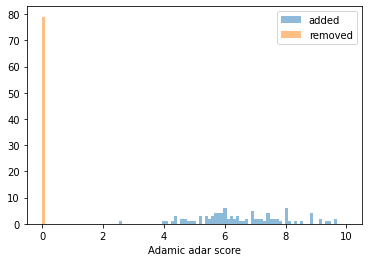

In [68]:
import random
import numpy
from matplotlib import pyplot

x = added_df_o['pos']
y = remove_df_o['pos']

bins = numpy.linspace(0, 10, 100)

pyplot.hist(x, bins, alpha=0.5, label='added')
pyplot.hist(y, bins, alpha=0.5, label='removed')
pyplot.legend(loc='upper right')
pyplot.xlabel('Adamic adar score')
pyplot.show()

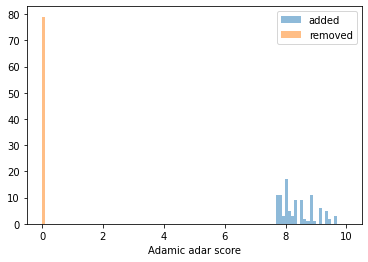

In [69]:
x = added_df['pos']
y = remove_df['pos']

bins = numpy.linspace(0, 10, 100)

pyplot.hist(x, bins, alpha=0.5, label='added')
pyplot.hist(y, bins, alpha=0.5, label='removed')
pyplot.xlabel('Adamic adar score')
pyplot.legend(loc='upper right')
pyplot.show()

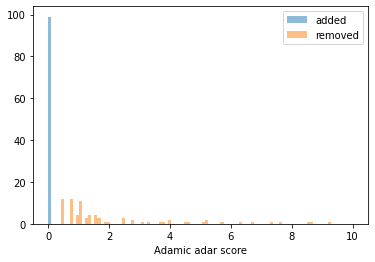

In [70]:
x = added_df_o['neg']
y = remove_df_o['neg']

bins = numpy.linspace(0, 10, 100)

pyplot.hist(x, bins, alpha=0.5, label='added')
pyplot.hist(y, bins, alpha=0.5, label='removed')
pyplot.legend(loc='upper right')
pyplot.xlabel('Adamic adar score')

pyplot.show()

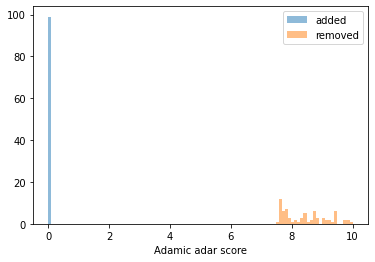

In [71]:
x = added_df['neg']
y = remove_df['neg']
bins = numpy.linspace(0, 10,100)
pyplot.hist(x, bins, alpha=0.5, label='added')
pyplot.hist(y, bins, alpha=0.5, label='removed')
pyplot.xlabel('Adamic adar score')
pyplot.legend(loc='upper right')
pyplot.show()

In [72]:
add_Edges = []
remove_Edges = []
add_o = []
remove_o = []
linkPredictWithAdamic('../eMCI.txt','../lMCI.txt')
added_df = pd.DataFrame()
added_df['first'] = [item[0] for item in add_Edges]  
added_df['second'] = [item[1] for item in add_Edges] 
added_df['pos'] = [item[2] for item in add_Edges] 
added_df['neg'] = [item[3] for item in add_Edges]  

remove_df = pd.DataFrame()
remove_df['first'] = [item[0] for item in remove_Edges]  
remove_df['second'] = [item[1] for item in remove_Edges] 
remove_df['pos'] = [item[2] for item in remove_Edges]
remove_df['neg'] = [item[3] for item in remove_Edges]  

added_df_o = pd.DataFrame()
added_df_o['first'] = [item[0] for item in add_o]  
added_df_o['second'] = [item[1] for item in add_o] 
added_df_o['pos'] = [item[2] for item in add_o] 
added_df_o['neg'] = [item[3] for item in add_o]  

remove_df_o = pd.DataFrame()
remove_df_o['first'] = [item[0] for item in remove_o]  
remove_df_o['second'] = [item[1] for item in remove_o] 
remove_df_o['pos'] = [item[2] for item in remove_o] 
remove_df_o['neg'] = [item[3] for item in remove_o] 


Number Of Edges:  1510
Number Of Nodes:  70
Number Of Edges:  1380
Number Of Nodes:  70
Number Of Removed Edges:  174
Number of new Edges: 44
[[ 0.          3.11362236  5.23574938 ...  0.          0.
   0.        ]
 [ 0.          0.          4.98951361 ...  0.          0.
   1.0203776 ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.         10.54420577
   6.16116902]
 [ 0.          0.          0.         ...  0.          0.
   6.16116902]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
score:  436
Matching Score::  0.5504587155963303
218


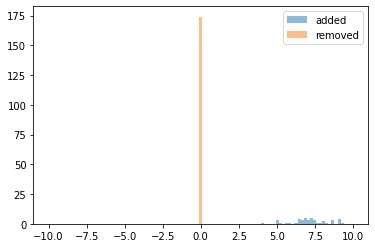

In [73]:
x = added_df_o['pos']
y = remove_df_o['pos']

bins = numpy.linspace(-10, 10, 100)

pyplot.hist(x, bins, alpha=0.5, label='added')
pyplot.hist(y, bins, alpha=0.5, label='removed')
pyplot.legend(loc='upper right')

pyplot.legend(loc='upper right')
pyplot.show()

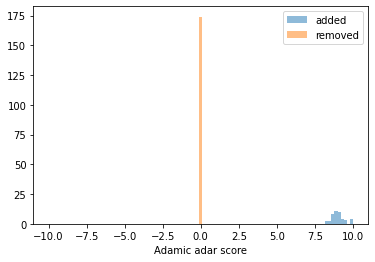

In [74]:
x = added_df['pos']
y = remove_df['pos']

bins = numpy.linspace(-10, 10, 100)

pyplot.hist(x, bins, alpha=0.5, label='added')
pyplot.hist(y, bins, alpha=0.5, label='removed')
pyplot.xlabel('Adamic adar score')
pyplot.legend(loc='upper right')
pyplot.show()

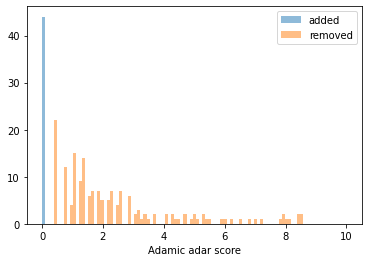

In [75]:
x = added_df_o['neg']
y = remove_df_o['neg']

bins = numpy.linspace(0, 10, 100)

pyplot.hist(x, bins, alpha=0.5, label='added')
pyplot.hist(y, bins, alpha=0.5, label='removed')
pyplot.legend(loc='upper right')
pyplot.xlabel('Adamic adar score')

pyplot.show()

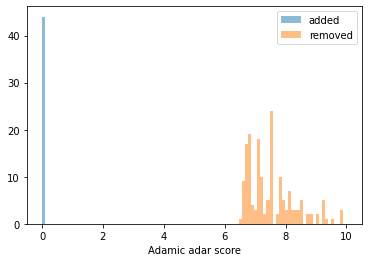

In [76]:
x = added_df['neg']
y = remove_df['neg']
bins = numpy.linspace(0, 10,100)
pyplot.hist(x, bins, alpha=0.5, label='added')
pyplot.hist(y, bins, alpha=0.5, label='removed')
pyplot.xlabel('Adamic adar score')
pyplot.legend(loc='upper right')
pyplot.show()

In [68]:
added_df = pd.DataFrame()
added_df['first'] = [item[0] for item in add_Edges]  
added_df['second'] = [item[1] for item in add_Edges] 
added_df['pos'] = [item[2] for item in add_Edges] 
added_df['neg'] = [item[3] for item in add_Edges]  

In [69]:
added_df

,first,second,pos,neg
0,11,57,9.967563,0.0
1,13,57,9.967563,0.0
2,24,60,9.929955,0.0
3,9,61,9.915047,0.0
4,25,63,9.414284,0.0
5,24,46,9.409892,0.0
6,25,59,9.399988,0.0
7,1,65,9.348648,0.0
8,12,62,9.316804,0.0
9,10,58,9.306522,0.0


In [70]:
remove_df = pd.DataFrame()
remove_df['first'] = [item[0] for item in remove_Edges]  
remove_df['second'] = [item[1] for item in remove_Edges] 
remove_df['pos'] = [item[2] for item in remove_Edges]
remove_df['neg'] = [item[3] for item in remove_Edges]  


In [71]:
remove_df

,first,second,pos,neg
0,40,67,0.0,11.719922
1,5,32,0.0,11.279592
2,53,66,0.0,10.919926
3,67,68,0.0,10.544206
4,5,33,0.0,10.201888
...,...,...,...,...
169,45,50,0.0,6.575444
170,35,50,0.0,6.574902
171,43,50,0.0,6.574902
172,49,50,0.0,6.574902


In [72]:
linkPredictWithAdamic('../lMCI.txt','../AD.txt')

Number Of Edges:  1380
Number Of Nodes:  70
Number Of Edges:  1364
Number Of Nodes:  70
Number Of Removed Edges:  90
Number of new Edges: 74
[[ 0.          4.4891421   6.87762485 ...  0.          0.
   0.        ]
 [ 0.          0.          5.34953783 ...  0.          0.
   1.2669629 ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.         10.78578827
   5.64653276]
 [ 0.          0.          0.         ...  0.          0.
   5.64653276]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
score:  328
Matching Score::  0.5701219512195121
164


In [73]:
linkPredictWithAdamic('../Normal.txt','../AD.txt')


Number Of Edges:  1490
Number Of Nodes:  70
Number Of Edges:  1364
Number Of Nodes:  70
Number Of Removed Edges:  172
Number of new Edges: 46
[[ 0.          4.94919543  4.88334419 ...  0.          0.
   0.        ]
 [ 0.          0.          4.27130143 ...  0.          0.
   1.01480864]
 [ 0.          0.          0.         ...  0.          0.
   0.73990106]
 ...
 [ 0.          0.          0.         ...  0.         11.11029861
   6.43460967]
 [ 0.          0.          0.         ...  0.          0.
   6.43460967]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
score:  436
Matching Score::  0.536697247706422
218
